In [ ]:
# Import necessary libraries for data handling, image processing, and model building
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add, DepthwiseConv2D, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from PIL import Image
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# Specify the path to the Air-Pollution-Image-Dataset-From-India-and-Nepal CSV files after extraction
Provide the file paths for the training, validation, and testing CSV files from the dataset.

In [9]:
# Define file paths for the dataset CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [10]:

def calculate_mean_std(train_csv_file):
    """
    Calculate the mean and standard deviation of the training dataset.
    """
    train_df = pd.read_csv(train_csv_file)
    root_dir = 'Datasets/Images/'
    train_images = [np.array(Image.open(root_dir + img_path).resize((224, 224))) for img_path in train_df['Filename'].values]
    mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
    std = np.std(train_images, axis=(0, 1, 2)) / 255.0
    return mean, std

mean, std = calculate_mean_std(train_csv_file)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Read the training, validation, and testing CSV files
train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

# Compute class weights to balance the dataset
classes = ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']
y_train_labels = train_df['AQI_Class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=y_train_labels)
index_class_weights = dict(enumerate(class_weights))

# Define image normalization function using ImageNet statistics
def normalize(image):
    image = image.astype('float32') / 255.0
    image = (image - mean) / std
    return image

# Set the image directory path
path = 'Datasets/Images'

# Configure training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=normalize,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

# Configure validation and test data generators without augmentation
val_test_datagen = ImageDataGenerator(preprocessing_function=normalize)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    seed=42
)

train_generator_raw = train_datagen.flow_from_dataframe(
    train_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
)

Found 7833 validated image filenames belonging to 6 classes.
Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# Build and train a model for AQI class image classification

In [12]:
def ghost_module(x, filters, kernel_size=3, stride=1, weight_decay=1e-3):
    init_channels = filters // 2
    
    # 主要卷積：生成初始特徵圖
    x = Conv2D(init_channels, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Ghost feature
    ghost = DepthwiseConv2D(kernel_size, padding='same')(x)
    ghost = Conv2D(init_channels, 1, strides=1, padding='same', kernel_regularizer=l2(weight_decay))(ghost)
    ghost = BatchNormalization()(ghost)
    ghost = Activation('relu')(ghost)
    
    x = Concatenate()([x, ghost])
    return x

def ghost_residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, weight_decay=1e-4):
    shortcut = x
    
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='valid', kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = ghost_module(x, filters, kernel_size, stride=stride, weight_decay=weight_decay)
    x = ghost_module(x, filters, kernel_size, stride=1, weight_decay=weight_decay)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def make_layer(x, filters, blocks, stride=1, weight_decay=1e-3):
    x = ghost_residual_block(x, filters, stride=stride, conv_shortcut=True, weight_decay=weight_decay)
    for _ in range(1, blocks):
        x = ghost_residual_block(x, filters, stride=1, conv_shortcut=False, weight_decay=weight_decay)
    return x

def build_ghost_resnet50(input_shape=(224, 224, 3), num_classes=6, weight_decay=1e-3, initializer=HeNormal(seed=42)):
    inputs = Input(shape=input_shape)
    
    # 初始卷積層
    x = Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = make_layer(x, 64, blocks=3, stride=1, weight_decay=weight_decay)   # Conv2_x
    x = make_layer(x, 128, blocks=4, stride=2, weight_decay=weight_decay)  # Conv3_x
    x = make_layer(x, 256, blocks=6, stride=2, weight_decay=weight_decay)  # Conv4_x
    x = make_layer(x, 512, blocks=3, stride=2, weight_decay=weight_decay)  # Conv5_x
    
    gap = GlobalAveragePooling2D()(x)
    gmp = GlobalMaxPooling2D()(x)
    x = Concatenate()([gap, gmp])
    x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay), kernel_initializer=initializer)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay), kernel_initializer=initializer)(x)
    
    model = Model(inputs, outputs)
    return model

weight_decay = 1e-4
model = build_ghost_resnet50(input_shape=(224, 224, 3), num_classes=6, weight_decay=weight_decay)

In [13]:
# Compile the model with optimizer, loss function, and metrics
from tensorflow.keras.metrics import F1Score
import tensorflow as tf

initial_learning_rate = 1e-3
optimizer = AdamW(learning_rate=initial_learning_rate, weight_decay=weight_decay)

def weighted_loss(class_weights, entropy_weight=0.01):
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        entropy = -tf.reduce_sum(y_pred * tf.math.log(y_pred), axis=-1)  # encourage peaky prediction
        return tf.reduce_mean(weights * ce + entropy_weight * entropy)
    return loss_fn

model.compile(
    optimizer=optimizer,
    loss=weighted_loss(list(index_class_weights.values())),
    metrics=['accuracy', F1Score(average='macro', name='f1_score')]
)

In [14]:
steps_per_epoch = len(train_generator)
val_steps = len(val_generator)

# Train the model with callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=150,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save('model.keras')

/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 76s 200ms/step - accuracy: 0.2258 - f1_score: 0.2192 - loss: 4.4798 - val_accuracy: 0.2751 - val_f1_score: 0.1522 - val_loss: 2.8006 - learning_rate: 0.0010
Epoch 2/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - accuracy: 0.3995 - f1_score: 0.3932 - loss: 2.7638 - val_accuracy: 0.1240 - val_f1_score: 0.0828 - val_loss: 10.6839 - learning_rate: 0.0010
Epoch 3/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - accuracy: 0.4072 - f1_score: 0.3984 - loss: 2.8476 - val_accuracy: 0.2557 - val_f1_score: 0.1446 - val_loss: 11.6514 - learning_rate: 0.0010
Epoch 4/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - accuracy: 0.3896 - f1_score: 0.3817 - loss: 2.7325 - val_accuracy: 0.2598 - val_f1_score: 0.2342 - val_loss: 7.5122 - learning_rate: 0.0010
Epoch 5/150
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - accuracy: 0.4362 - f1_score: 0.4315 - loss: 2.5255 - val_accuracy: 0.5227 - val_f1_score: 0.5095 - val_loss: 1.9612 - learning_rate: 0.0010
Epoch 6/

# plot your Training Accuracy and validation accuracy here

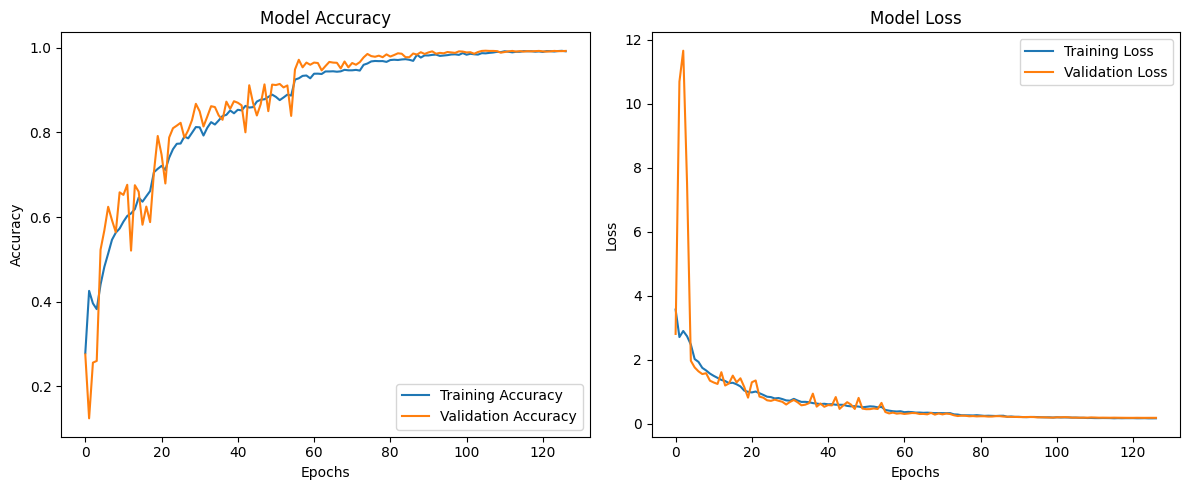

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [16]:
def safe_predict(model, generator):
    generator.reset()
    y_pred = model.predict(generator, verbose=1)
    return y_pred

test_probabilities = safe_predict(model, test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('Outputs/Results.csv', index=False)

75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

2025-06-23 11:58:29.759298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2176', 76 bytes spill stores, 76 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


In [17]:
# Evaluate the model on the test data
test_generator.reset()
test_loss, test_accuracy, test_f1_score = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")

probs = safe_predict(model, test_generator)  # shape = (N, 6)
entropy = -np.sum(probs * np.log(probs + 1e-9), axis=1)

print(f"平均 entropy: {np.mean(entropy):.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9976 - f1_score: 0.8005 - loss: 0.1548
Test Loss: 0.1540, Test Accuracy: 0.9971, Test F1 Score: 0.9971
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
平均 entropy: 0.0092


In [18]:
# Get classification prediction
cls_pred = safe_predict(model, test_generator)
y_pred = np.argmax(cls_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# F1 Score per class
from sklearn.metrics import f1_score
f1_scores = f1_score(y_true, y_pred, average=None)
average_f1_score = f1_score(y_true, y_pred, average='macro')

for i, f1 in enumerate(f1_scores):
    print(f"Class {i}: F1 Score = {f1:.4f}")
print(f"Average F1 Score: {average_f1_score:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Class 0: F1 Score = 0.9952
Class 1: F1 Score = 0.9984
Class 2: F1 Score = 0.9965
Class 3: F1 Score = 0.9972
Class 4: F1 Score = 0.9989
Class 5: F1 Score = 0.9966
Average F1 Score: 0.9971


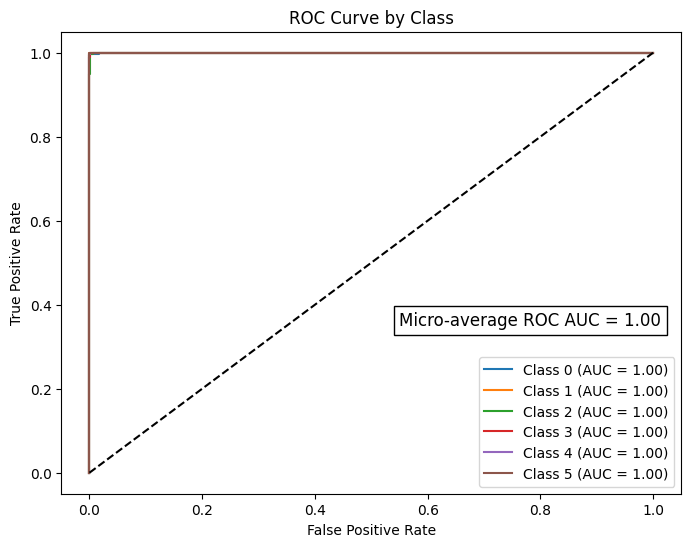

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))
roc_auc_scores = roc_auc_score(y_true_binarized, cls_pred, average='micro')

# Plot ROC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], cls_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], cls_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class')
plt.legend(loc='lower right')
plt.text(0.55, 0.35, f'Micro-average ROC AUC = {roc_auc_scores:.2f}', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black'))
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = safe_predict(model, train_generator_raw)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = safe_predict(model, val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = safe_predict(model, test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator_raw.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator_raw.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

2025-06-23 11:59:10.432132: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2176', 4 bytes spill stores, 4 bytes spill loads

2025-06-23 11:59:10.448004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2176', 64 bytes spill stores, 64 bytes spill loads

2025-06-23 11:59:10.484624: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2176', 100 bytes spill stores, 100 bytes spill loads



245/245 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Overall MAE - Training: 0.0043
Overall RMSE - Training: 0.0783
Overall MAE - Validation: 0.0123
Overall RMSE - Validation: 0.1629
Overall MAE - Testing: 0.0041
Overall RMSE - Testing: 0.0808


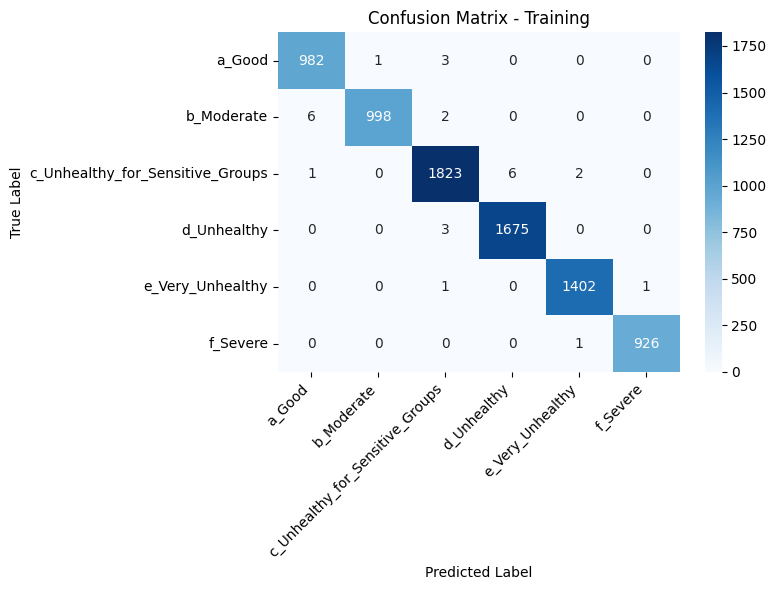

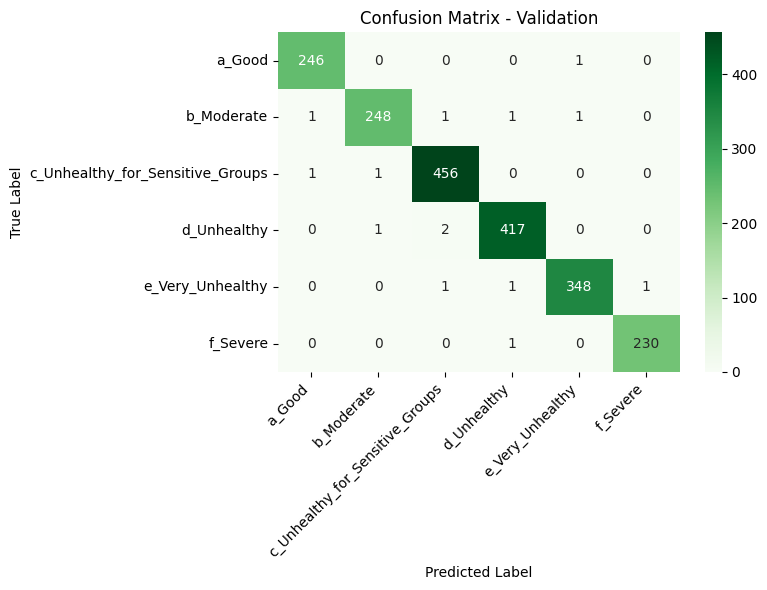

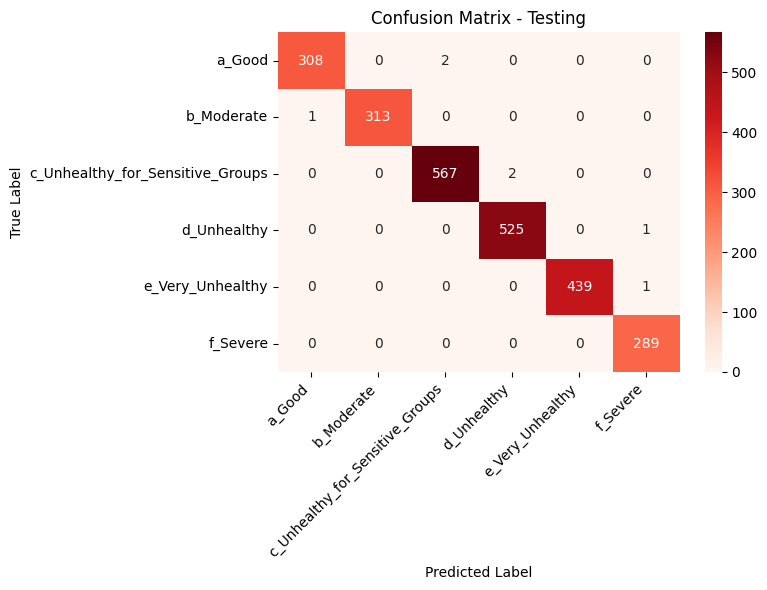

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator_raw.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()
